In [1]:
"""
This notebook analyzes the statistics of register tokens in Flextok.
"""

'\nThis notebook analyzes the statistics of register tokens in Flextok.\n'

In [4]:
# add the parent directory to the Python path
import sys
import os
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt


['/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python311.zip', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/lib-dynload', '', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages', '/BS/data_mani_compress/work/thesis/thesis/external/guided-diffusion', '/BS/data_mani_compress/work/thesis/thesis/external/DenseFlow', '/BS/data_mani_compress/work/thesis/thesis']


In [ ]:
def compute_token_position_counts(token_ids, vocab_size=64000):
    """
    Compute how often each token ID appears at each token position.

    Args:
        token_ids: np.ndarray of shape (N, T)
            N = number of images (e.g. 50000)
            T = number of tokens per image (e.g. 256)
            Values are token IDs in [0, vocab_size-1]

        vocab_size: int
            Size of the token vocabulary (default: 64000)

    Returns:
        counts: np.ndarray of shape (vocab_size, T)
            counts[v, p] = number of times token ID v appears
                           at position p across the dataset
    """
    token_ids = np.asarray(token_ids)
    N, T = token_ids.shape

    # Initialize counts array
    counts = np.zeros((vocab_size, T), dtype=np.int32)

    # For each position p, count token frequencies at that position
    for p in range(T):
        # token_ids[:, p] has shape (N,)
        ids_at_pos = token_ids[:, p]

        # Count occurrences of each token ID at this position
        # minlength ensures we get a vector of length vocab_size
        counts[:, p] = np.bincount(ids_at_pos, minlength=vocab_size)

    return counts


In [6]:
# read the register tokens from the .npz file
register_tokens_npz = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagnet_register_tokens/imagnet_val_register_tokens.npz"
data = np.load(register_tokens_npz)
register_tokens = data['token_ids']

In [ ]:
print(f"Register token shape: {register_tokens.shape}") # [50000, 256]
print(register_tokens[0])

In [8]:
# Build counts: for each token id and position, how often does it occur
# Result shape: (vocab_size, 256) with counts[token_id, position]
# This loops over positions and uses np.bincount for efficiency.

# Infer vocabulary size from the data (expected ~64_000)
vocab_size = int(register_tokens.max()) + 1
num_images, num_positions = register_tokens.shape

print(f"Inferring vocab_size={vocab_size} from data; positions={num_positions}, images={num_images}")

# Allocate counts: use uint32 to save memory (fits counts up to >4 billion)
# the counts are initalized as zero, so initially, for all the token ids, 
# they all appear is no positions.
counts = np.zeros((vocab_size, num_positions), dtype=np.uint32)

# Fill counts column-wise (position-wise)
for pos in range(num_positions):
    # Count how many times each token id appears at this position across all images
    col_counts = np.bincount(register_tokens[:, pos], minlength=vocab_size)
    # Store into the counts matrix
    counts[:, pos] = col_counts.astype(np.uint32)

print("Done building counts matrix.")
print("counts shape:", counts.shape)


Inferring vocab_size=64000 from data; positions=256, images=50000
Done building counts matrix.
counts shape: (64000, 256)


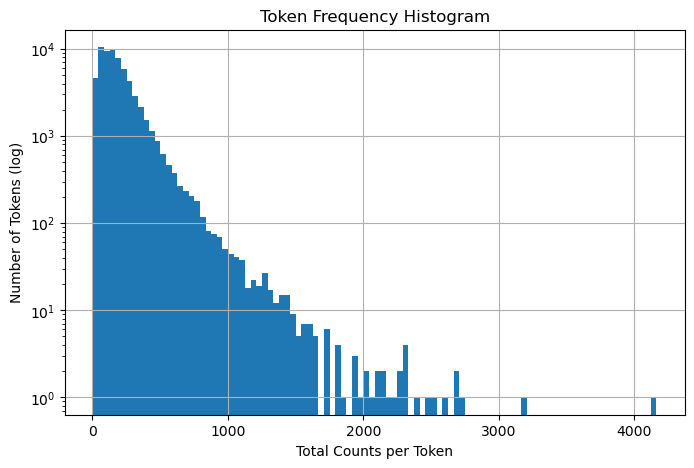

In [ ]:
counts = compute_token_position_counts(register_tokens)

# Total occurrences per token
total_counts = counts.sum(axis=1)

# Mean position of each token (weighted)
positions = np.arange(256)
mean_position = (counts * positions).sum(axis=1) / (total_counts + 1e-8)


In [ ]:
# token frequency histogram
plt.figure(figsize=(8, 5))
plt.hist(total_counts, bins=100, log=True)
plt.xlabel("Total Counts per Token")
plt.ylabel("Number of Tokens (log)")
plt.title("Token Frequency Histogram")
plt.grid(True)
plt.show()

In [ ]:
num_total_tokens = 64000
num_used_tokens = len(np.unique(register_tokens.flatten()))
num_dead = num_total_tokens - num_used_tokens
print("Dead tokens:", num_dead)

# find number of tokens appearing only 1s. counts is of shape (vocab_size, 256)
num_ones = np.sum(total_counts >= 3000)
print("Tokens appearing more than 3k times:", num_ones)

Dead tokens: 0
Tokens appearing more than 3k times: 2


In [34]:
def token_position_mean_variance(counts):
    """
    Compute mean and variance of token positions for each token ID.

    Args:
        counts: np.ndarray of shape (V, T)
            counts[v, p] = number of times token v appears at position p

    Returns:
        mean_pos: np.ndarray of shape (V,)
        var_pos:  np.ndarray of shape (V,)
    """
    V, T = counts.shape
    positions = np.arange(T)

    # Total occurrences per token
    total = counts.sum(axis=1)  # [V]

    # Avoid division by zero for unused tokens
    eps = 1e-8

    # E[p | token]
    mean_pos = (counts * positions).sum(axis=1) / (total + eps)

    # E[p^2 | token]
    mean_pos_sq = (counts * (positions ** 2)).sum(axis=1) / (total + eps)

    # Var[p | token]
    var_pos = mean_pos_sq - mean_pos ** 2

    return mean_pos, var_pos


In [35]:
mean_pos, var_pos = token_position_mean_variance(counts)

In [36]:
T = counts.shape[1]
max_var = (T**2 - 1) / 12  # variance of uniform distribution
norm_var = var_pos / max_var

In [35]:
print(type(norm_var))

<class 'numpy.ndarray'>


In [39]:
# find mean of norm_var
mean_norm_var = np.mean(norm_var)
std_norm_var = np.std(norm_var)
print("Standard deviation of normalized variance of token positions:", std_norm_var)
print("Mean normalized variance of token positions:", mean_norm_var)

Standard deviation of normalized variance of token positions: 0.1092774323340795
Mean normalized variance of token positions: 0.9652359571810664


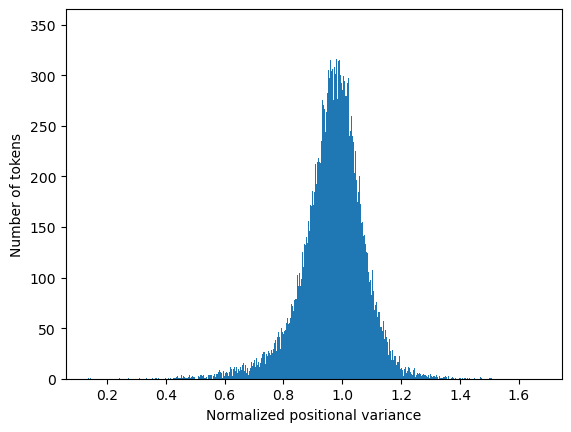

In [38]:
# plot normalized variance histogram
plt.hist(norm_var, bins=1500)
plt.xlabel("Normalized positional variance")
plt.ylabel("Number of tokens")
plt.show()


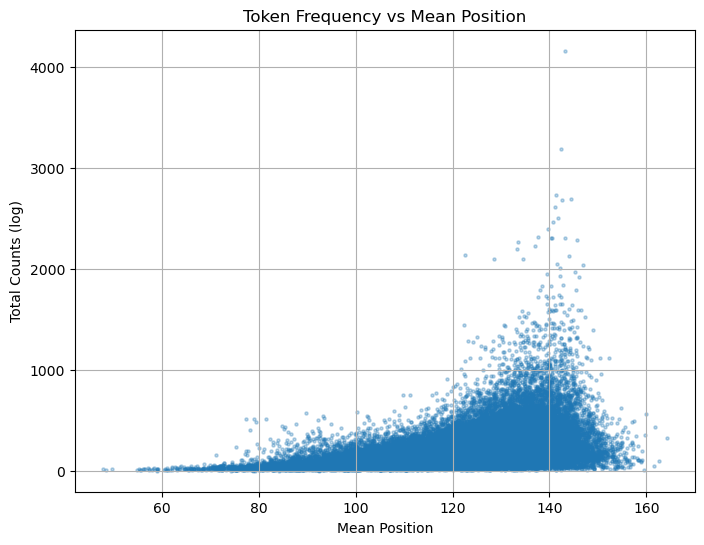

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(mean_position, total_counts, s=5, alpha=0.3)
#plt.yscale("log")
plt.xlabel("Mean Position")
plt.ylabel("Total Counts (log)")
plt.title("Token Frequency vs Mean Position")
plt.grid(True)
plt.show()


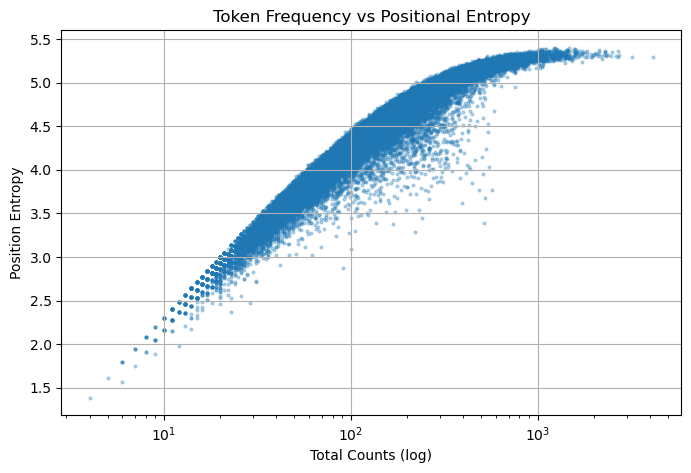

In [48]:

p = counts / (total_counts[:, None] + 1e-8)
entropy = -np.sum(p * np.log(p + 1e-8), axis=1)
plt.figure(figsize=(8, 5))
plt.scatter(total_counts, entropy, s=4, alpha=0.3)
plt.xscale("log")
plt.xlabel("Total Counts (log)")
plt.ylabel("Position Entropy")
plt.title("Token Frequency vs Positional Entropy")
plt.grid(True)
plt.show()


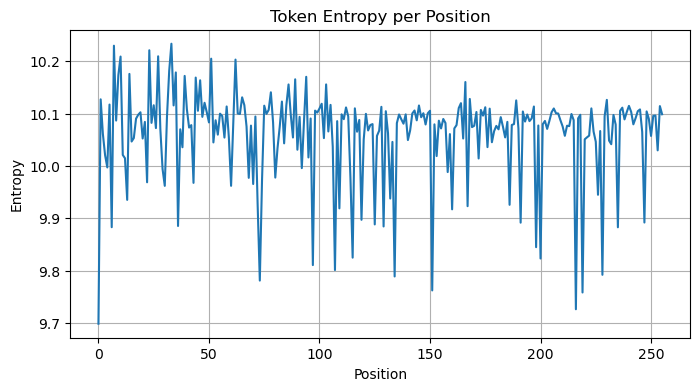

In [49]:
pos_counts = counts.sum(axis=0)
p_pos = counts / (pos_counts[None, :] + 1e-8)
pos_entropy = -np.sum(p_pos * np.log(p_pos + 1e-8), axis=0)

plt.figure(figsize=(8, 4))
plt.plot(pos_entropy)
plt.xlabel("Position")
plt.ylabel("Entropy")
plt.title("Token Entropy per Position")
plt.grid(True)
plt.show()
